# Représentation 2D de Force Atlas 

### Importation des bibliothéques

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import gridspec
from networkx.drawing.nx_pydot import read_dot

Ce code définit une classe appelée Point, qui est utilisé pour représenter un point dans un espace 2D avec des coordonnées x et y. La classe dispose d’un Init Méthode qui initialise les coordonnées x, y du point, et une charge utile facultative qui peut être n’importe quelle donnée supplémentaire associée au point. La classe a également REPR et Str des méthodes qui permettent de représenter le point dans un format lisible. La classe a également une méthode appelée distance_to qui prend un autre point comme argument et retourne la distance euclidienne entre les deux points.

In [2]:
class Point:
    
    def __init__(self, x, y, payload=None):
        self.x, self.y = x, y
        self.payload = payload

    def __repr__(self):
        return '{}: {}'.format(str((self.x, self.y)), repr(self.payload))
    
    def __str__(self):
        return 'P({:.2f}, {:.2f})'.format(self.x, self.y)

    def distance_to(self, other):
        try:
            other_x, other_y = other.x, other.y
        except AttributeError:
            other_x, other_y = other
        return np.hypot(self.x - other_x, self.y - other_y)

**Le code ci-dessus définit une classe 'Rect' qui représente un rectangle.**

La classe possède une méthode init qui intègre les arguments suivants :
cx, cy (coordonnées centrales du rectangle)
W, H (largeur et hauteur du rectangle)

Il calcule ensuite la west_edge, la east_edge, la north_edge south_edge du rectangle en utilisant les coordonnées centrales, la largeur et la hauteur.

Il a également les méthodes suivantes:
REPR et Str Méthodes qui renvoient la représentation sous forme de chaîne de l’objet rectangle.
Méthode Contains(point) qui vérifie si le point se trouve à l’intérieur du rectangle.
Intersects(other), méthode qui vérifie si l’objet rectangle croise un autre objet Rectangle.
Méthode draw(ax, c='k', lw=1) qui permet de dessiner le rectangle sur un axe Matplotlib.

Il est utilisé pour définir un rectangle sur un graphique et vérifier si un point est à l’intérieur du rectangle ou non. La méthode draw est utilisée pour dessiner un rectangle sur un axe matplotlib.

In [3]:
class Rect:
    
    def __init__(self, cx, cy, w, h):
        self.cx, self.cy = cx, cy
        self.w, self.h = w, h
        self.west_edge, self.east_edge = cx - w/2, cx + w/2
        self.north_edge, self.south_edge = cy - h/2, cy + h/2

    def __repr__(self):
        return str((self.west_edge, self.east_edge, self.north_edge, self.south_edge))
                

    def __str__(self):
        return '({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(self.west_edge, self.north_edge, self.east_edge, self.south_edge)
                    
    def contains(self, point):
        try:
            point_x, point_y = point.x, point.y
        except AttributeError:
            point_x, point_y = point

        return (point_x >= self.west_edge and point_x <  self.east_edge and point_y >= self.north_edge and point_y < self.south_edge)
                
    def intersects(self, other):
        return not (other.west_edge > self.east_edge or other.east_edge < self.west_edge or other.north_edge > self.south_edge or other.south_edge < self.north_edge)
                    
    def draw(self, ax, c='k', lw=1, **kwargs):
        x1, y1 = self.west_edge, self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        ax.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c=c, lw=lw, **kwargs)

**QuadTreeClasse comporte les méthodes suivantes :**

Init: initialise le QuadTree avec une limite (une instance de la classe Rect), un nombre maximal de points par nœud feuille (la valeur par défaut est 1) et la profondeur du nœud actuel dans l’arborescence (la valeur par défaut est 0)

Diviser : subdivise la frontière en quatre quadrants (Nord-Ouest, Nord-Est, Sud-Est et Sud-Ouest)

insert : insère un point dans le QuadTree en vérifiant si le point se trouve dans la limite et en l’insérant récursivement dans le quadrant enfant approprié si le QuadTree a été divisé

requête : recherche tous les points d’une limite donnée en vérifiant si la limite coupe la limite du QuadTree et en effectuant une recherche récursive dans les quadrants enfants si c’est le cas.

draw : dessine les limites du QuadTree à l’aide de la méthode draw de la classe Rect et appelle récursivement la méthode draw des quadrants enfants si le quadrant est divisé

Len: renvoie le nombre de points dans l’arborescence QuadTree.

In [4]:
class QuadTree:
    
    def __init__(self, boundary, max_points=1, depth=0):
        self.boundary = boundary
        self.max_points = max_points
        self.points = []
        self.depth = depth
        self.divided = False

    def __str__(self):
        sp = ' ' * self.depth * 2
        s = str(self.boundary) + '\n'
        s += sp + ', '.join(str(point) for point in self.points)
        if not self.divided:
            return s
        return s + '\n' + '\n'.join([sp + 'nw: ' + str(self.nw), sp + 'ne: ' + str(self.ne),sp + 'se: ' + str(self.se), sp + 'sw: ' + str(self.sw)])
                
    def divide(self):
        cx, cy = self.boundary.cx, self.boundary.cy
        w, h = self.boundary.w / 2, self.boundary.h / 2
        self.nw = QuadTree(Rect(cx - w/2, cy - h/2, w, h), self.max_points, self.depth + 1)                      
        self.ne = QuadTree(Rect(cx + w/2, cy - h/2, w, h), self.max_points, self.depth + 1)                       
        self.se = QuadTree(Rect(cx + w/2, cy + h/2, w, h), self.max_points, self.depth + 1)                    
        self.sw = QuadTree(Rect(cx - w/2, cy + h/2, w, h), self.max_points, self.depth + 1)                    
        self.divided = True

    def insert(self, point):
        if not self.boundary.contains(point):
            return False
        if len(self.points) < self.max_points:
            self.points.append(point)
            return True
        if not self.divided:
            self.divide()
        return (self.ne.insert(point) or self.nw.insert(point) or self.se.insert(point) or self.sw.insert(point))
            
    def query(self, boundary, found_points):
        if not self.boundary.intersects(boundary):
            return False
        for point in self.points:
            if boundary.contains(point):
                found_points.append(point)
        if self.divided:
            self.nw.query(boundary, found_points)
            self.ne.query(boundary, found_points)
            self.se.query(boundary, found_points)
            self.sw.query(boundary, found_points)
        return found_points

    def __len__(self):
        npoints = len(self.points)
        if self.divided:
            npoints += len(self.nw)+len(self.ne)+len(self.se)+len(self.sw)
        return npoints

    def draw(self, ax):
        self.boundary.draw(ax)
        if self.divided:
            self.nw.draw(ax)
            self.ne.draw(ax)
            self.se.draw(ax)
            self.sw.draw(ax)

Ce code crée une structure de données Quadtree 2D pour stocker et organiser les points dans un espace 2D. Il crée un ensemble de points aléatoires, puis crée un objet QuadTree à l’aide d’une limite spécifiée (domaine) et d’un nombre maximal de points par nœud feuille. Il insère ensuite tous les points dans le QuadTree à l’aide de la méthode insert().

Le QuadTree est ensuite visualisé à l’aide de la méthode draw(), qui montre les limites des différents nœuds de l’arborescence. Les points sont également tracés sur le même graphique à l’aide du nuage de points de matplotlib. Les limites x et y sont définies et les ticks x et y sont supprimés pour une visualisation plus propre. Le graphique final montre les points et les limites des nœuds QuadTree.

Le code imprime également le nombre total de points dans le domaine, qui doit être le même que le nombre de points qui ont été insérés dans le QuadTree.

Number of points in the domain = 85


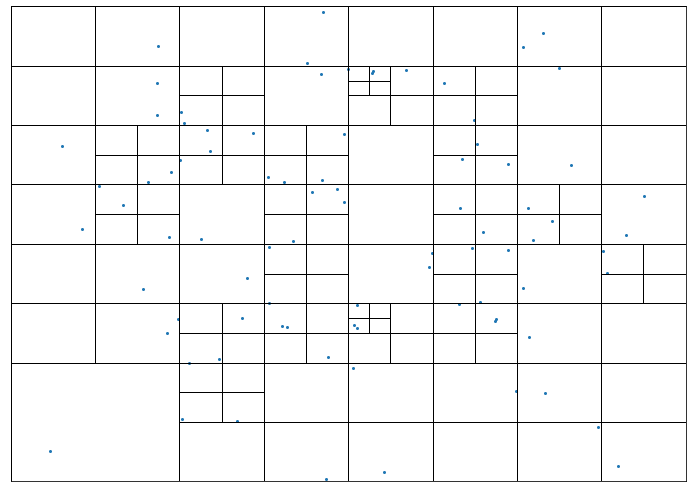

In [5]:
# Exemple d'utlisation de QuadTree sur un ensemble de points

DPI = 72
np.random.seed(60)

# La heuteur et la largeur du rectangle
width, height = 600, 400

# Le nombre de Noeud à insérer 
N = 100

# Création des noeuds aléatoirement
coords = np.random.randn(N, 2) * height/3 + (width/2, height/2)
points = [Point(*coord) for coord in coords]

# Création d'un QuadTree
domain = Rect(width/2, height/2, width, height)
qtree = QuadTree(domain, 1)

# Insertion des points dans un QuadTree
for point in points:
    qtree.insert(point)

# Affichage du nombre de points dans le QuadTree
print('Number of points in the domain =', len(qtree))

# Affichage du graphique avec Matplotlib
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(0, width)
ax.set_ylim(0, height)
qtree.draw(ax)

# Affichage du nuage du points
ax.scatter([p.x for p in points], [p.y for p in points], s=4)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### La fonction qui calcule la Complexité

La fonction prend en compte trois arguments :calculate_complexity
func qui est une fonction qui prend un graphique et le nombre d’itérations comme entrée.
graph est la structure de données du graphe sur laquelle la fonction func sera appliqué.
nbr_iterations est le nombre d’itérations que la fonction func s’exécutera sur le graphique.

La fonction calcule et renvoie ensuite le temps nécessaire à la fonction func pour compléter son exécution sur le graphe donné en stockant le temps courant avant et après l’exécution de la fonction et en prenant la différence. Cela peut être utilisé pour mesurer la complexité temporelle de la fonction.

In [6]:
import time
def calculate_complexity(func, graph, nbr_iterations):
    start_time = time.time()
    func(graph, nbr_iterations)
    end_time = time.time()
    return end_time - start_time

### Création d'un graph avec des coordonées aléatoires

Le code crée un graphique temporaire G_tmp en lisant un fichier ".dot". Il crée ensuite un graphique vide G. Il itére ensuite sur les nœuds dans G_tmp les ajouter à G avec des coordonnées x et y aléatoires. Enfin, il ajoute tous les bords de G_tmp À G et crée une copie de G appelée GG.

In [7]:
# Créer un graph
G_tmp = nx.Graph(read_dot('benzène.dot'))
G = nx.Graph()

# Ajouter des noeuds avec des coordonnées aléatoires
for node in G_tmp.nodes():
    x = float(np.random.uniform(0, 600, size=1))
    y = float(np.random.uniform(0, 400, size=1))
    G.add_node(node, pos=(x, y))

# Ajouter les arrêts entre les noeuds
G.add_edges_from(G_tmp.edges())

GG = G.copy()

### Calcule de la Force d'Attraction

Ce code définit une fonction « force_attraction » qui prend un graphe « G » et un nœud « nœud » comme entrées. La fonction calcule la force d’attraction agissant sur le « nœud » dans le graphique. La force est calculée en itérant sur toutes les arêtes du graphique et en ajoutant la valeur de la force entre le nœud et chacun de ses nœuds voisins. La force entre deux nœuds est calculée à l’aide de la loi de Hooke, qui stipule que la force est proportionnelle à la distance entre les deux nœuds. Dans cette implémentation, la constante de proportionnalité est définie sur « k » et la distance entre les nœuds est calculée à l’aide de la distance euclidienne. La valeur de force finale est renvoyée par la fonction.

In [8]:
def force_attraction(G, node):
    force = 0
    k = 1
    for u, v in G.edges():
        if u==node or v==node:
            x1, y1 = G.nodes[u]['pos'][0], G.nodes[u]['pos'][1]
            x2, y2 = G.nodes[v]['pos'][0], G.nodes[v]['pos'][1]
            distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            force = force + (k * distance)
    return force

### Calcule de la Force de Répulsion

Le code définit une fonction « force_repulsion » qui prend un graphe (G) et un nœud (nœud) comme entrées. La fonction initialise une variable « force » à 0 et une variable « k » à 1. Il itére ensuite sur tous les nœuds du graphique et vérifie si le nœud courant est le même que le nœud d’entrée (nœud). Si c’est le cas, il itére ensuite sur tous les autres nœuds du graphique et vérifie si le nœud actuel n’est pas le même que le nœud d’entrée. Si ce n’est pas le cas, la fonction calcule le degré du nœud d’entrée et du nœud courant dans la deuxième itération. Il obtient ensuite les coordonnées des deux nœuds et calcule la distance euclidienne entre eux. Enfin, il calcule la force de répulsion entre les deux nœuds en utilisant le degré, la distance et k et l’ajoute à la force totale. La fonction renvoie ensuite la force totale.

**La masse de degré : Cette formule calcule la masse d'un nœud en comptant le nombre de liens (ou arcs) qui y arrivent ou en partent. Elle est souvent utilisée pour les graphes non orientés : masse(i) = degree(i)**

In [9]:
def force_repulsion(G, node):
    force = 0
    k = 1
    for i in G.nodes():
        if i == node:
            for j in G.nodes():
                if i != j:
                    m1 = nx.degree(G)[i]
                    m2 = nx.degree(G)[j]
                    # Obtenir les coordonnées des noeuds
                    x1, y1 = G.nodes[i]['pos'][0], G.nodes[i]['pos'][1]
                    x2, y2 = G.nodes[j]['pos'][0], G.nodes[j]['pos'][1]
                    # Calculer la distance euclidienne entre les noeuds
                    distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                    # Calculer la force répulsive
                    force = force + (k * (m1+m2) / distance**2)
    return force

### Calcule de la Somme des Forces

Ce code définit une fonction « somme_forces » qui prend un graphe (G) et un nœud (nœud) comme entrées. La fonction appelle deux autres fonctions, « force_attraction » et « force_repulsion » en passant les mêmes entrées (G, nœud) aux deux fonctions. Il ajoute ensuite la valeur de retour des deux fonctions et renvoie la somme des deux valeurs en sortie de la fonction « somme_forces ». La fonction suppose que les fonctions « force_attraction » et « force_repulsion » ont déjà été définies et sont disponibles.

In [10]:
def somme_forces(G, node):
    fatt = force_attraction(G, node)
    frep = force_repulsion(G, node)
    return fatt + frep

### Calcule de l'Acceleration

Ce code définit une fonction « acceleration_node » qui prend un graphe (G) et un nœud (nœud) comme entrées. La fonction appelle une autre fonction « somme_forces » en lui passant les mêmes entrées (G, nœud) et retourne la sortie de la fonction « somme_forces » comme sortie de la fonction « acceleration_node ». La fonction suppose que la fonction « somme_forces » a déjà été définie et qu’elle peut être utilisée.
La fonction calcule l’accélération d’un nœud dans le graphe en fonction de la somme des forces agissant sur lui. Il renvoie la force totale sur le nœud.

In [11]:
def acceleration_node(G, node):
    return somme_forces(G, node)

### Calcule de la Vitesse

Ce code définit une fonction « vitesse_node » qui prend un graphe (G) et un nœud (nœud) comme entrées. La fonction initialise une variable « vitesseInitiale » à 0 et une autre variable « temps » à 0,005. Il calcule ensuite la vitesse du nœud en utilisant la formule : vélocité = vitesse initiale + temps * accélération. Pour ce faire, il appelle la fonction « acceleration_node » en lui passant les mêmes entrées (G, nœud) et multiplie la sortie de cette fonction par la valeur de la variable « temps ». La fonction renvoie ensuite cette vitesse en sortie de la fonction « vitesse_node ».

In [12]:
def vitesse_node(G, node):
    vitesseInitiale = 0
    temps = 0.005
    return vitesseInitiale + temps * acceleration_node(G, node)

## Mise à jours des coordonnées avec la Fonoction Force Atlas 2

Ce code définit une fonction « forceAtlas2D » qui prend un graphe (G) et un certain nombre d’itérations (nbr_iterations) comme entrées. La fonction initialise d’abord une variable « temps » à 0,005. Il effectue ensuite une boucle imbriquée qui itére sur tous les nœuds du graphique pour un certain nombre d’itérations spécifiées par le paramètre d’entrée « nbr_iterations ». Pour chaque nœud, il obtient d’abord les anciennes coordonnées x et y du nœud. Ensuite, il calcule les nouvelles coordonnées x et y du nœud en appelant la fonction « vitesse_node » et en multipliant la sortie par la valeur de la variable « temps ». Enfin, il met à jour les coordonnées du nœud dans le graphique en utilisant la fonction « nx.set_node_attributes ».

La fonction implémente l’algorithme Force Atlas 2D qui est une méthode pour disposer de grands réseaux dans l’espace 2D. Il simule les forces physiques qui agissent sur les nœuds du réseau et utilise ces forces pour déterminer la disposition finale du réseau. Il s’agit d’un algorithme itératif qui met à jour les coordonnées des nœuds dans le graphique pour minimiser les forces agissant sur eux sur un certain nombre d’itérations.

Il convient de noter que le pas de temps de 0,005 n’est pas une valeur standard et qu’il peut être trop petit ou trop grand en fonction du problème spécifique et de la précision souhaitée. Il faudra peut-être l’ajuster en conséquence.
En outre, le nombre d’itérations est un paramètre crucial qui affecte la qualité de la mise en page et le temps de calcul. Il doit être réglé en fonction de la taille du graphique et de la précision souhaitée.

In [13]:
def forceAtlas2D(G, nbr_iterations):
    temps = 0.005
    for i in range(nbr_iterations):
        for n in G.nodes():
            old_x, old_y = G.nodes[n]['pos'][0], G.nodes[n]['pos'][1]
            # Appel à la fonction vitesse_node() qui se charge d'appeler les autres fonctions qui calculent les forces
            new_x = old_x + temps * vitesse_node(G, n)
            new_y = old_y + temps * vitesse_node(G, n)
            # Mise à jours des coordonnées x et y
            nx.set_node_attributes(G, {n: (new_x, new_y)}, 'pos')

### Affichage de QuadTree

Ce code définit une fonction « afficher_quatree » qui prend un graphe (G) comme entrée. La fonction définit d’abord la largeur et la hauteur du graphique sur 600 et 400 respectivement. Il crée un dictionnaire vide « dicts » puis itére sur tous les nœuds du graphique, en ajoutant le nom et les coordonnées du nœud au dictionnaire. Ensuite, il crée une liste d’objets « Point » en utilisant les coordonnées et les noms du dictionnaire.

La fonction crée ensuite un « domaine » rectangulaire en utilisant les variables width et height, et initialise un objet QuadTree « root1 » avec ce domaine et une capacité maximale de 1. Il crée ensuite une liste vide « liste_points » et insère les objets Point dans le QuadTree et la liste.

La fonction crée ensuite une figure, définit les limites x et y du graphique et dessine le QuadTree sur le graphique. Il ajoute ensuite les étiquettes de nœuds au graphique et trace les nœuds sous forme de petits points. Il définit également les xticks et yticks pour qu’ils soient vides, inverse l’axe y et trace les arêtes du graphique.
Enfin, il appelle la fonction « plt.show() » pour afficher le graphique à l’écran.

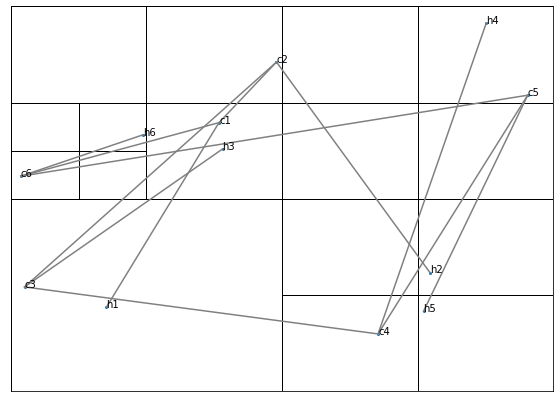

In [14]:
def afficher_quatree(G):
    width, height = 600, 400
    dicts = {}
    for n in G.nodes():
        dicts[n] = (G.nodes[n]['pos'][0], G.nodes[n]['pos'][1])
    randomPoints = [Point(*coord, nom) for nom, coord in dicts.items()]
    domain = Rect(width/2, height/2, width, height)
    root1 = QuadTree(domain, 1)
    liste_points = []
    for node in randomPoints:
        newPoint = Point(node.x, node.y)
        liste_points.append(newPoint)
        root1.insert(newPoint)    
    fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
    ax = plt.subplot()
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    root1.draw(ax)
    for i, label in enumerate([label for label, coord in dicts.items()]):
        plt.text(randomPoints[i].x, randomPoints[i].y, label)  
    ax.scatter([p.x for p in liste_points], [p.y for p in liste_points], s=4)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    for u, v in G.edges():
        x1, y1 = G.nodes[u]['pos'][0], G.nodes[u]['pos'][1]
        x2, y2 = G.nodes[v]['pos'][0], G.nodes[v]['pos'][1]
        ax.plot([x1, x2], [y1, y2], color ='gray',alpha=1)
    plt.show()

# Affichage de QuadTree
afficher_quatree(G)

### Appel de la fonction calculate_complexity() sur le QuadTree

In [15]:
calculate_complexity(forceAtlas2D, G, 1000)

2.5407602787017822

### Affichage du graphe après la Mise à Jour des coordonnées

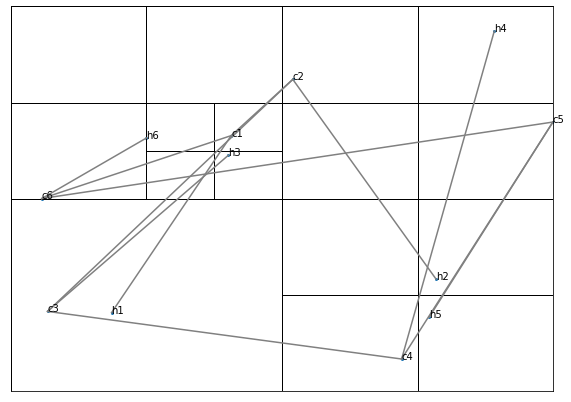

In [16]:
afficher_quatree(G)

### Calcule de la gravité

Ce code définit une fonction « calculate_gravity » qui prend un graphique (G) et un certain nombre d’itérations (nbr_iterations) comme entrées. La fonction initialise d’abord les variables pour le pas de temps, la vitesse initiale, la force d’attraction, la force de répulsion, la force totale et la valeur de la constante k. Ensuite, il exécute une boucle imbriquée qui itére sur tous les nœuds du graphique pour un certain nombre d’itérations spécifiées par le paramètre d’entrée « nbr_iterations ».

In [17]:
def calculate_gravity(G, nbr_iterations):
    temps = 0.005
    vitesseInitiale = 0
    att_force = rep_force = sum_force = 0
    # Donner une valeur à la constante k
    k = 1
    # Itérer sur toutes les arêtes du graph
    u = 'h1'
    for i in range(nbr_iterations):
        for v in G.nodes():
            if u!=v:
                # Masse des noeuds (masse de degré)
                m1 = nx.degree(G)[u]
                m2 = nx.degree(G)[v]
                
                # Obtenir les coordonnées des noeuds
                x1, y1 = G.nodes[u]['pos'][0], G.nodes[u]['pos'][1]
                x2, y2 = G.nodes[v]['pos'][0], G.nodes[v]['pos'][1]
                
                # Calculer la distance euclidienne entre les noeuds
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                
                # Calculer la force d'attraction
                att_force = k * distance
                
                # Calculer la force répulsive
                rep_force = k * (m1+m2) / distance**2
                
                # somme des forces
                sum_force = att_force + rep_force
                
                # Calcule de la vitesse
                vitesse = vitesseInitiale + temps * sum_force
                
                # Mise à jours des position
                new_x = x2 + temps * vitesse
                new_y = y2 + temps * vitesse
                
                # Mise à jours des coordonnées x et y
                nx.set_node_attributes(G, {v: (new_x, new_y)}, 'pos')

In [18]:
calculate_complexity(calculate_gravity, GG, 1000)

0.11568903923034668

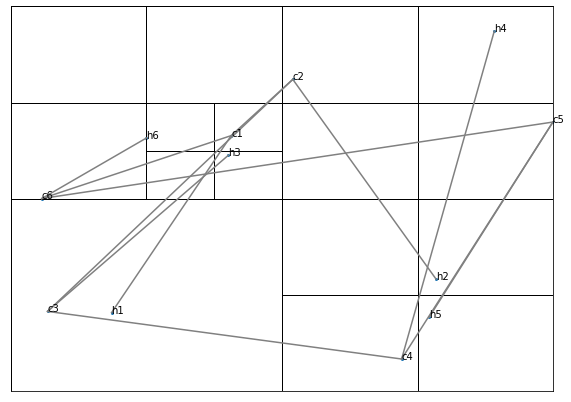

In [19]:
afficher_quatree(G)